# Text Analytics Tutorial
### Patrick van Kessel
#### Senior Data Scientist, Pew Research Center

These materials are adapted from workshops I did in 2018 and 2019 for AAPOR, NYAAPOR, the World Bank, and IBM, with a lot of help from an old colleague of mine, Mika Jugovich. You can access a GitHub repository containing this notebook and the data sample here: https://github.com/patrickvankessel/text-analysis-workshop 

## Loading in the data

We'll use a sample from the Kaggle Amazon Fine Food Reviews dataset. The full dataset can be found here: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [1]:
import pandas as pd

In [2]:
sample = pd.read_csv("https://raw.githubusercontent.com/patrickvankessel/text-analysis-workshop/main/kaggle_sample.csv")

In [3]:
print(len(sample))

10000


Let's see what's in here.

In [4]:
sample.head()

,Unnamed: 0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,467510,467511,B003WECB5S,A2G0LDLGXKQFYP,behrlekidsmom,2,2,3,1304640000,Holes in wrappers,The kids said the taste/flavor is fine but A L...
1,1,291775,291776,B000FVYUFA,A34O5D0QRGV29N,a Dallas reader,1,1,5,1188432000,Absolutely the best!,How can something this good be good for you to...
2,2,180629,180630,B000CQBZQK,A3ER3V2E06DH7D,"A. K. Kaw ""AKK""",0,1,5,1247529600,Tea meant for a late evening,"I love Earl Grey Tea. I have tried Tazo, Twini..."
3,3,412055,412056,B000CQC05K,A39Y02EJ310WJR,"Tech Girl ""Wendy""",2,2,5,1236729600,"Full-flavored, delicious tea that you can drin...",This tea is so fruity and full-flavored that i...
4,4,139779,139780,B001BCXTGS,A1LC1NMRA1ZEDZ,M. Garcia,1,1,5,1244332800,My cat only eats this brand,My cat is not crazy about the snapper and shri...


### Examine the data

Run the cell below a few times, let's take a look at our text and see what it looks like.  Always take a look at your raw data.

In [5]:
sample.sample(10)['Text'].values

array(["Maggie went nuts over these Instinct Raw Boost Bites, and she is a very finicky cat. Liddy was mildly interested, with a nibble here and a nibble there, and Frankie is just peculiar; she will only eat her dull kibble food. The list of ingredients on the box of these freeze dried treats looks mighty fine, with everything from chicken to ground flaxseeds and broccoli. Each treat is a 1 ½ inch round, with the slight consistency and look of a shortbread cookie, and has a fairly decent smell for the human nose. You can easily break them into 4 or more pieces for your cat.<br /><br />These round treats are for both dogs and cats, and are estimated as 1 or 2 for every 20 lbs. of weight. At the rate Maggie would like to eat these, she'd have to let out the buttons in her fur jacket. It's nice though that I've found something she likes, and that it's such a healthy treat. Thank you Nature's Variety for making a treat made of good, natural food for our fussy fur friends. Packaging is goo

### Preprocess the text (clean it up!)

I don't know about you, but I noticed some junk in our data - HTML and URLs.  Let's clear that out first.  We'll also take this opportunity to lemmatize the words - to do that, we'll install NLTK's WordNet library.

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import re
from nltk.stem import WordNetLemmatizer

# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # First we'll use regular expressions to strip out links and HTML tags
    text = re.sub(r'http[a-zA-Z0-9\&\?\=\?\/\:\.]+\b', ' ', text)
    text = re.sub(r'\<[^\<\>]+\>', ' ', text)
    # Next, let's clear out all punctuation and replace it with whitespace
    text = re.sub(r'\W+', ' ', text) 
    # And clear out numbers
    text = re.sub(r'[0-9]+', ' ', text)
    # And then lowercase
    text = text.lower()
    # This isn't going to be perfect - ideally we expand contractions first
    # And also deal with spelling corrections
    # But this will work well enough for now
    
    # Next, let's split on whitespace and then lemmatize each token
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(x) for x in tokens]
    text = " ".join(tokens)
  
    return text

sample['Text'] = sample['Text'].map(clean_text)

Let's see what our data look like now that we've processed the text

In [8]:
sample.sample(10)['Text'].values

array(['i also tried my first taste sample at costco and it wa the pomegranate flavor so i bought a bottle and started using it daily month later hoodia offered a new flavor at costco and that wa the acai berry i liked that even better and many month went by continuing to consume my daily dose of hoodia fiber every morning a couple month ago i went to replenish my supply and to my dismay there wa nothing but nopal cactus flavor on the shelf at my local costco and even though the thought of cactus flavor did not sound appealing i purchased bottle and the next morning when i gulped my little shot down it almost came right back up the rest of the month i would plug my nose every time i had to swallow that swill and i would have some kind of food at the ready so i could immediately take a bite of it to wash away the nasty taste that wa left in my mouth from the cactus crap i have now stopped using the product and will not use it again until they offer the the acai berry or pomegranate flav

## TF-IDF Vectorization (Feature Extraction)

Just to be safe, let's add some additional words to a standard list of English stop words.

In [9]:
from sklearn.feature_extraction import stop_words as sklearn_stop_words
# Grab standard English stopwords
stop_words = set(sklearn_stop_words.ENGLISH_STOP_WORDS)
# And add in some of our own ("like" is really common and doesn't tell us much)
stop_words = stop_words.union(set([
    "www", "http", "https", "br", "amazon", "href", "wa", "ha",
    "like", "just",
]))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Okay, now let's tokenize our text and turn it into numbers

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=stop_words, # Remove stopwords
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [11]:
tfidf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Because vocabulary spaces are really big, by default we work with sparse matrices.  We can expand the sparse matrix with `.todense()` and compute sums like a normal dataframe.  Let's check out the top 20 words.

In [12]:
ngram_df = pd.DataFrame(tfidf.todense(), columns=ngrams) 

In [13]:
ngram_df.head()

,able,absolute,absolutely,acceptable,according,account,acid,acidic,acidity,acquired,act,active,actual,actually,add,added,addicted,addicting,addictive,adding,addition,additional,additive,adequate,admit,adopted,adult,advantage,advertised,advertising,advice,affect,afford,affordable,afraid,afternoon,aftertaste,agave,age,aged,...,word,work,worked,worker,working,workout,world,worried,worry,worse,worst,worth,wouldn,wow,wrap,wrapped,wrapper,write,writing,written,wrong,wrote,xylitol,yeah,year,yeast,yellow,yes,yesterday,yogurt,young,yr,yuck,yum,yummy,zero,zevia,zico,zip,zuke
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.381701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17755,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
ngram_df.sum().sort_values(ascending=False)[:20]

coffee     316.980063
good       308.366277
taste      306.032427
great      296.119454
tea        286.896549
love       283.353920
product    281.596502
flavor     278.327891
food       213.044387
dog        205.873217
really     178.868613
price      175.593576
time       165.726609
make       165.491621
cup        165.306249
buy        163.445115
best       162.054263
bag        154.881833
ve         151.040409
don        145.061858
dtype: float64

### Word co-occurrences

We can also explore word co-occurrences - the words that most frequently appear together in the same documents

In [15]:
count_vectorizer = CountVectorizer(
    max_df=.9, 
    min_df=50, 
    stop_words=stop_words, 
    binary=True
)
counts = count_vectorizer.fit_transform(sample['Text'])
ngrams = count_vectorizer.get_feature_names()
cooccurs = (counts.T * counts) 
cooccurs.setdiag(0)
cooccurs = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
cooccurs.head()

,able,absolutely,acid,actual,actually,add,added,addicted,adding,addition,admit,adult,afternoon,aftertaste,age,ago,agree,air,allergic,allergy,almond,alot,alternative,amazing,american,animal,anymore,apple,appreciate,area,aren,aroma,arrived,artificial,ask,asked,ate,available,average,avoid,...,wasn,waste,watch,water,way,weak,website,week,weight,weird,wellness,went,wet,wheat,white,wife,wine,winter,wish,won,wonder,wonderful,word,work,worked,working,world,worry,worse,worst,worth,wouldn,wow,wrapped,wrong,year,yes,yogurt,yum,yummy
able,0,10,4,3,30,19,16,1,8,0,10,3,1,4,6,14,5,2,1,8,2,2,6,9,6,4,8,3,6,7,8,4,17,7,3,2,2,17,1,4,...,22,3,6,24,47,5,9,23,9,4,2,13,7,10,11,8,1,5,12,21,2,17,5,29,4,3,8,5,2,3,19,13,2,5,5,50,11,3,4,2
absolutely,10,0,2,6,23,17,11,2,4,5,5,4,1,4,2,8,4,2,3,5,10,3,8,15,1,2,4,6,2,3,4,4,9,5,0,1,3,6,3,4,...,5,3,1,17,26,0,7,10,11,4,8,13,3,5,4,3,0,4,5,12,0,20,6,20,2,4,1,3,4,4,19,8,4,2,4,28,10,4,1,6
acid,4,2,0,1,10,12,8,2,2,1,3,6,1,3,0,2,3,0,0,1,1,2,2,4,2,4,4,3,1,2,2,6,0,7,2,2,1,4,4,3,...,6,0,1,18,14,3,3,6,2,0,1,5,1,7,9,0,3,0,7,3,0,9,2,6,3,3,5,4,2,2,10,5,3,0,1,9,4,2,1,2
actual,3,6,1,0,14,8,9,0,3,4,2,0,1,2,0,5,0,3,0,1,2,0,2,1,1,0,1,2,1,0,3,1,4,8,1,1,2,6,3,2,...,5,0,1,10,19,1,3,6,4,0,4,3,1,4,4,2,1,0,2,3,0,4,1,10,1,0,0,1,5,0,1,8,1,3,1,9,1,2,1,1
actually,30,23,10,14,0,33,33,4,17,7,8,3,3,12,4,13,8,7,4,10,12,1,13,13,3,4,11,12,8,8,11,8,20,22,6,5,12,17,10,9,...,25,10,1,48,54,7,8,29,16,9,12,27,11,14,11,5,2,5,10,26,9,16,6,43,8,12,11,4,10,7,23,23,6,9,12,51,17,7,0,12


In [16]:
melted = pd.melt(
    cooccurs.reset_index().rename(columns={"index": "ngram1"}), 
    id_vars=["ngram1"], var_name="ngram2", value_name="count"
).drop_duplicates()
melted['pair'] = melted.apply(lambda x: ", ".join(sorted([x['ngram1'], x['ngram2']])), axis=1)
melted[['pair', 'count']].drop_duplicates().sort_values("count", ascending=False).head(25)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,pair,count
386678,"good, taste",1000
395912,"great, taste",796
347690,"flavor, taste",788
347164,"flavor, good",756
386476,"good, product",656
719102,"product, taste",640
395528,"great, love",635
347173,"flavor, great",632
395710,"great, product",610
386161,"good, great",599


## Classification

Let's go back to the TF-IDF matrix and use it to do some classification

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # Remove any words that appear in more than 90% of our documents
    min_df=5, # Remove words that appear in fewer than 5 document
    ngram_range=(1, 1), # Only extract unigrams
    stop_words=stop_words, # Remove stopwords
    max_features=2500 # Grab the 2500 most common words (based on above constraints)
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

Let's make an outcome variable.  How about we try to predict 5-star reviews, and then maybe helpfulness?

In [18]:
sample['good_score'] = sample['Score'].map(lambda x: 1 if x == 5 else 0)
sample['was_helpful'] = ((sample['HelpfulnessNumerator'] / sample['HelpfulnessDenominator']).fillna(0.0) > .80).astype(int)

In [19]:
column_to_predict = 'good_score'

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import metrics

results = []
kfolds = StratifiedKFold(n_splits=5)

We just created an object that'll split the data into fifths, and then iterate over it five times, holding out one-fifth each time for testing.  Let's do that now.  Each "fold" contains an index for training rows, and one for testing rows.  For each fold, we'll train a basic linear Support Vector Machine, and evaluate its performance.

In [21]:
for i, fold in enumerate(kfolds.split(tfidf, sample[column_to_predict])):
    
    train, test = fold 
    print("Running new fold, {} training cases, {} testing cases".format(len(train), len(test)))
    
    clf = svm.LinearSVC(
        max_iter=1000,
        penalty='l2',
        class_weight='balanced',
        loss='squared_hinge'
    )
    # We picked some decent starting parameters, but you can try out different ones
    # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html 
    # If you're ambitious - check out the Scikit-Learn documentation and test out different models
    # http://scikit-learn.org/stable/supervised_learning.html
    # XGBoost is one of my favorites, and there's an Scikit-Learn wrapper for it
    # https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
    
    training_text = tfidf[train]
    training_outcomes = sample[column_to_predict].loc[train]
    clf.fit(training_text, training_outcomes) # Train the classifier on the training data
    
    test_text = tfidf[test]
    test_outcomes = sample[column_to_predict].loc[test]
    predictions = clf.predict(test_text) # Get predictions for the test data
    
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(
        test_outcomes, # Compare the predictions against the true outcomes
        predictions
    )
    
    results.append({
        "fold": i,
        "outcome": 0,
        "precision": precision[0],
        "recall": recall[0],
        "fscore": fscore[0],
        "support": support[0]
    })
    
    results.append({
        "fold": i,
        "outcome": 1,
        "precision": precision[1],
        "recall": recall[1],
        "fscore": fscore[1],
        "support": support[1]
    })
    
results = pd.DataFrame(results)

Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases
Running new fold, 8000 training cases, 2000 testing cases


How'd we do?

In [22]:
print(results.groupby("outcome").mean()[['precision', 'recall']])
print(results.groupby("outcome").std()[['precision', 'recall']])

         precision    recall
outcome                     
0         0.640849  0.698769
1         0.817060  0.774468
         precision    recall
outcome                     
0         0.008227  0.020460
1         0.010000  0.005666


Now we know that our model is pretty stable and reasonably performant, we can fit and transform the full dataset.

In [23]:
clf.fit(tfidf, sample[column_to_predict])  
predictions = clf.predict(tfidf)
print(metrics.classification_report(sample[column_to_predict], predictions))
print(metrics.confusion_matrix(sample[column_to_predict], predictions))
# You can see that the performance looks better when you run the model on data it's already seen

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3655
           1       0.92      0.86      0.89      6345

    accuracy                           0.86     10000
   macro avg       0.85      0.86      0.86     10000
weighted avg       0.87      0.86      0.87     10000

[[3164  491]
 [ 868 5477]]


And now we can see what the most predictive features are.

In [24]:
import numpy as np

ngram_coefs = sorted(zip(ngrams, clf.coef_[0]), key=lambda x: x[1], reverse=True)
ngram_coefs[:10]

[('highly', 3.1013130917137777),
 ('best', 2.444743275433364),
 ('love', 2.306616889244311),
 ('perfect', 2.2929034381917535),
 ('favorite', 2.1199982849994745),
 ('wonderful', 2.0063344263556337),
 ('cancer', 1.943117438070201),
 ('fabulous', 1.8950412837848212),
 ('satisfied', 1.869043540556362),
 ('addicted', 1.8094489171934698)]

What happens if you change the outcome column to "was_helpful" and re-run it again?  Can you think of ways to improve this?  Add more stopwords?  Include bigrams in addition to unigrams?

## Topic Modeling

In [25]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [26]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #{}: {}".format(
            topic_idx,
            ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        ))

Let's find some topics.  We'll check out non-negative matrix factorization (NMF) first.

In [27]:
nmf = NMF(n_components=10, random_state=42, alpha=.1, l1_ratio=.5).fit(tfidf)
# Try out different numbers of topics (change n_components)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
print("\nTopics in NMF model:")
print_top_words(nmf, ngrams, 10)


Topics in NMF model:
Topic #0: flavor, taste, sugar, ve, really, make, water, tried, don, little
Topic #1: coffee, cup, strong, roast, bold, flavor, blend, keurig, dark, pod
Topic #2: tea, green, bag, drink, cup, iced, stash, black, taste, earl
Topic #3: dog, treat, love, food, chew, bone, small, size, teeth, toy
Topic #4: cat, food, eat, dry, wellness, canned, chicken, ingredient, love, vet
Topic #5: product, store, price, order, buy, local, grocery, shipping, time, box
Topic #6: great, love, snack, price, deal, taste, healthy, recommend, highly, tasting
Topic #7: chocolate, bar, dark, snack, nut, peanut, candy, protein, sweet, calorie
Topic #8: chip, bag, salt, potato, kettle, snack, vinegar, salty, flavor, fat
Topic #9: good, really, price, taste, pretty, quality, tasting, quite, fresh, enjoy


LDA is an other popular topic modeling technique

In [28]:
lda = LatentDirichletAllocation(n_components=10, random_state=42).fit(tfidf)
# Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
# doc_topic_prior (alpha) - lower alpha means documents will be composed of fewer topics (higher means a more uniform distriution across all topics)
# topic_word_prior (beta) - lower beta means topics will be composed of fewer words (higher means a more uniform distribution across all words)
print("\nTopics in LDA model:")
print_top_words(lda, ngrams, 10)


Topics in LDA model:
Topic #0: coffee, cup, flavor, taste, drink, good, strong, great, roast, tea
Topic #1: taste, bar, sugar, good, great, flavor, chocolate, product, snack, calorie
Topic #2: sauce, chip, salt, great, pasta, flavor, soup, good, cheese, spicy
Topic #3: chocolate, great, love, good, cereal, snack, box, cider, curry, bag
Topic #4: tea, popcorn, taste, flavor, good, bag, drink, green, chai, great
Topic #5: dog, treat, love, chew, teeth, toy, bone, size, training, great
Topic #6: product, price, arrived, gift, order, great, store, good, item, box
Topic #7: sleep, product, night, help, container, calm, great, link, good, jack
Topic #8: food, cat, dog, product, love, eat, good, year, bag, time
Topic #9: store, baby, love, product, great, price, time, buy, year, good


We can use the topic models the same way we did our classifier - everything in Scikit-Learn follows the same fit/transform paradigm.  So, let's get the topics for our documents.

In [29]:
doc_topics = pd.DataFrame(lda.transform(tfidf))

In [30]:
doc_topics.head()

,0,1,2,3,4,5,6,7,8,9
0,0.024099,0.024098,0.783103,0.024103,0.024096,0.024099,0.024098,0.024106,0.024102,0.024097
1,0.750107,0.027767,0.027766,0.027764,0.027766,0.027765,0.027768,0.027763,0.027767,0.027766
2,0.016939,0.016949,0.016949,0.016937,0.815528,0.016946,0.016941,0.016941,0.016946,0.048924
3,0.023150,0.023149,0.023147,0.023146,0.791670,0.023147,0.023147,0.023151,0.023146,0.023147
4,0.021649,0.021662,0.021655,0.021648,0.021648,0.021651,0.021647,0.021650,0.805141,0.021650


In [31]:
topic_column_names = ["topic_{}".format(c) for c in doc_topics.columns]
doc_topics.columns = topic_column_names

Next we use Pandas to join the topics with the original sample dataframe

In [32]:
sample_with_topics = pd.concat([sample, doc_topics], axis=1)

Let's look for patterns by running some means and correlations

In [33]:
topic_columns = [col for col in sample_with_topics.columns if col.startswith("topic_")]
sample_with_topics.groupby("good_score").mean()[topic_columns]

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
good_score,,,,,,,,,,
0,0.183903,0.226292,0.065056,0.041901,0.076930,0.058601,0.071276,0.033828,0.172662,0.069551
1,0.142316,0.226311,0.087173,0.047796,0.090577,0.068197,0.092969,0.034686,0.127523,0.082451


In [34]:
for topic in topic_column_names:
    print("{}: {}".format(topic, sample_with_topics[topic].corr(sample_with_topics['Score'])))

topic_0: -0.025292235465098026
topic_1: 0.012046757693743672
topic_2: 0.06959235818628244
topic_3: 0.02344640187646894
topic_4: 0.035996895241293216
topic_5: 0.034091342273425244
topic_6: 0.04691101261547622
topic_7: -0.0016848166526520594
topic_8: -0.13859039591384575
topic_9: 0.01900770995053607


Here's an example of a linear regression

In [35]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

training_data = sample_with_topics[topic_column_names[:-1]] 
# We're leaving a column out to avoid multicollinearity

regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(training_data, sample_with_topics['Score'])
coefficients = regression.coef_
for topic, coef in zip(topic_column_names[:-1], coefficients):
  print("{}: {}".format(topic, coef))

topic_0: -0.2126938279684611
topic_1: -0.08431147949125337
topic_2: 0.39070487682918603
topic_3: 0.10179168229468157
topic_4: 0.1007044347349962
topic_5: 0.1935251748886603
topic_6: 0.18368702620144362
topic_7: -0.2113170836932562
topic_8: -0.7277794219956406


Sadly Scikit-Learn doesn't make it easy to get p-values or a regression report like you'd normally expect of something like R or Stata.  Scikit-Learn is more about prediction than statistical analysis; for the latter, we can use Statsmodels.  

In [36]:
import statsmodels.api as sm

training_data = sm.add_constant(training_data)
regression = sm.OLS(sample_with_topics['Score'], training_data)
results = regression.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     30.11
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.00e-52
Time:                        21:36:38   Log-Likelihood:                -16832.
No. Observations:               10000   AIC:                         3.368e+04
Df Residuals:                    9990   BIC:                         3.376e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2597      0.071     59.682      0.0

### K-Means Clustering

We can also check out other unsupervised methods like clustering.  I borrowed/modified some of this code from http://brandonrose.org/clustering

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=50, tol=.01, n_jobs=-1)
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans.fit(tfidf)
clusters = kmeans.labels_.tolist() # You can merge these back into the data if you want

In [38]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 
for i, closest_ngrams in enumerate(centroids):
    print("Cluster #{}: {}".format(i, ", ".join(np.array(ngrams)[closest_ngrams[:8]])))

Cluster #0: dog, treat, food, love, chew, product, good, bone
Cluster #1: coffee, cup, flavor, strong, taste, good, roast, blend
Cluster #2: cooky, gluten, free, cookie, good, taste, great, love
Cluster #3: drink, water, sugar, taste, flavor, good, sweet, soda
Cluster #4: bar, chocolate, taste, dark, good, snack, great, nut
Cluster #5: product, great, store, price, good, grocery, local, taste
Cluster #6: cat, food, eat, love, treat, wellness, chicken, dry
Cluster #7: tea, taste, green, bag, flavor, good, drink, cup
Cluster #8: chip, bag, potato, flavor, kettle, snack, great, salt
Cluster #9: good, great, flavor, taste, love, really, time, make


### Agglomerative/Hierarchical Clustering

Instead of specifying the number of clusters upfront, now we're going to use hierarchical clustering to characterize how similar words are to each other, again based on their co-occurrence within documents. To keep things manageable, we'll use a smaller set of 500 words.

In [39]:
# This Python library lets us produce graphics
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.25, # Focus on less common, more unique words
    min_df=5, 
    ngram_range=(1, 1), 
    stop_words=stop_words, 
    max_features=200 # <- smaller set of words
)
tfidf = tfidf_vectorizer.fit_transform(sample['Text'])
ngrams = tfidf_vectorizer.get_feature_names()

In [41]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# We'll use cosine similarity to get word similarities based on document overlap
# This produces a matrix of every word compared to every other word
# With a value of 0 - 1, indicating how often they occur together in the same documents
# To get document similarities in terms of word overlap, just drop the .transpose()!
similarities = cosine_similarity(tfidf.transpose()) 
distances = 1 - similarities # Converts to distances
clusters = linkage(distances, method='ward') # Run hierarchical clustering on the distances

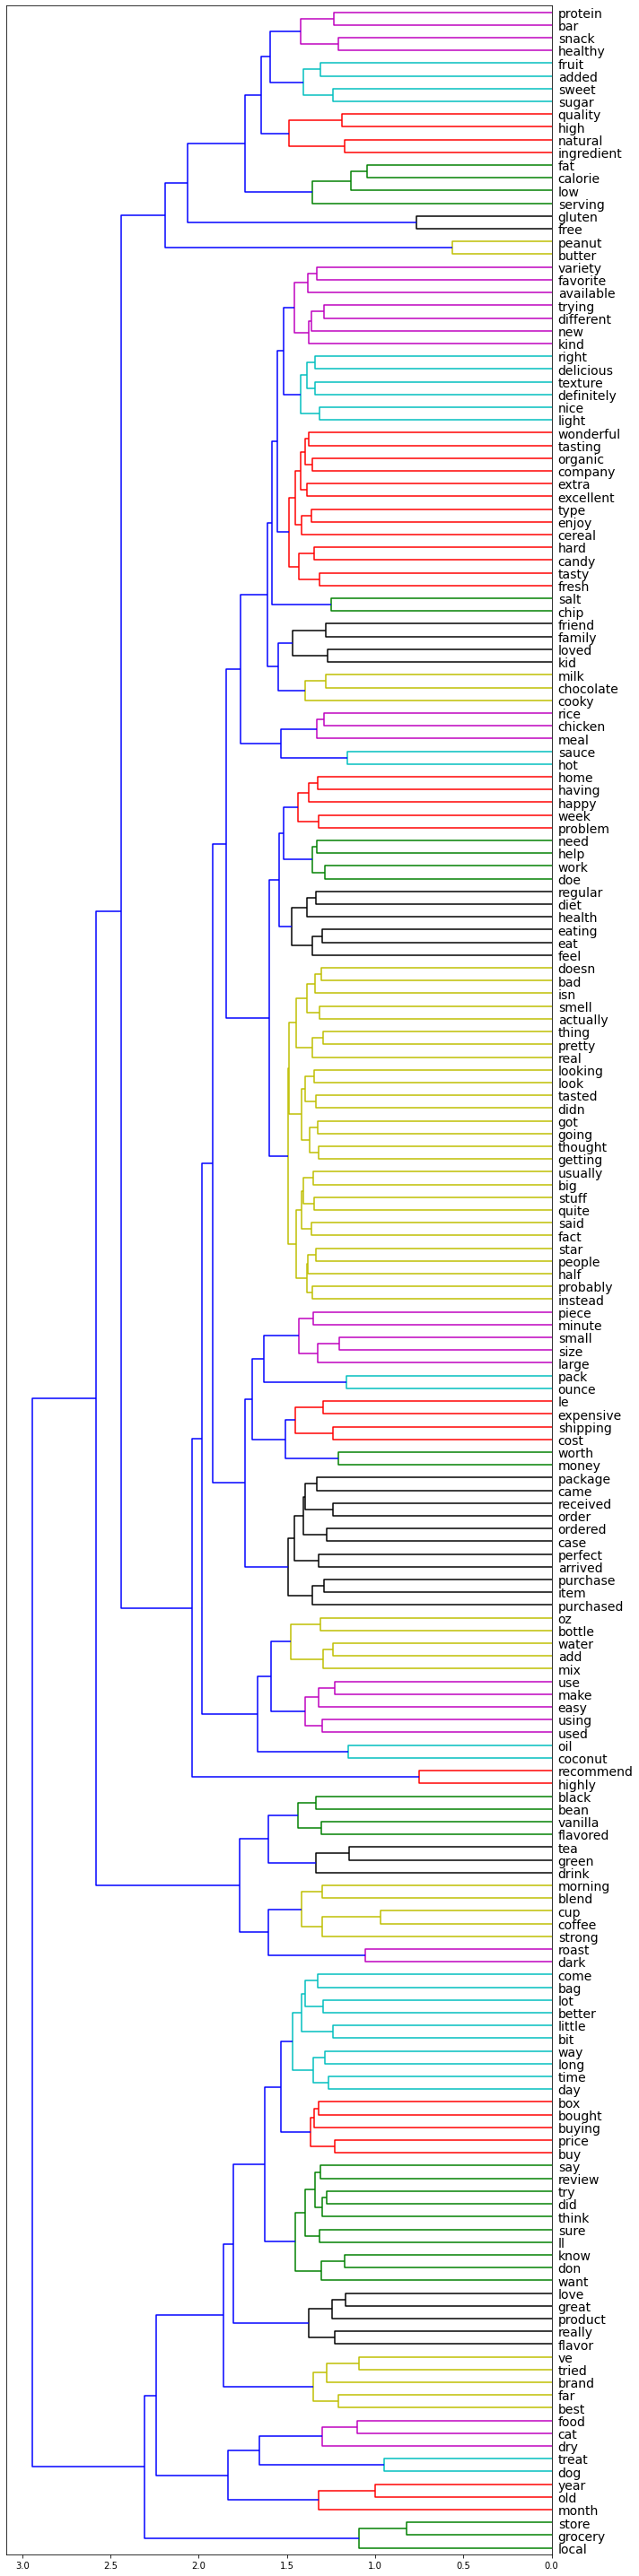

In [42]:
fig, ax = plt.subplots(figsize=(10, 40))
ax = dendrogram(
    clusters, 
    labels=ngrams, 
    orientation="left", 
    leaf_font_size=14, 
    color_threshold=1.5
)
plt.tight_layout()

## Pew Analytics

In [43]:
!pip install zipcodes
!pip install git+https://github.com/pewresearch/pewtils#egg=pewtils
!pip install git+https://github.com/pewresearch/pewanalytics#egg=pewanalytics

In [44]:
from pewanalytics.text import TextCleaner, TextDataFrame

In [45]:
sample = pd.read_csv("https://raw.githubusercontent.com/patrickvankessel/AAPOR-Text-Analysis-2019/master/kaggle_sample.csv")

In [46]:
cleaner = TextCleaner()
sample['Text'] = sample['Text'].map(cleaner.clean)
sample['Text'].head()

0    kid said taste flavor fine lot sucker hole pla...
1    good good favorite lundberg does_not know make...
2    love earl grey tea tried tazo twinings earl gr...
3    tea fruity flavored make great iced tea caffei...
4    cat crazy snapper shrimp variety love yellow f...
Name: Text, dtype: object

In [47]:
sample['good_score'] = sample['Score'].map(lambda x: 1 if x == 5 else 0)
sample['was_helpful'] = ((sample['HelpfulnessNumerator'] / sample['HelpfulnessDenominator']).fillna(0.0) > .80).astype(int)

In [48]:
tdf = TextDataFrame(
  sample, "Text",
  min_df=5, max_df=.9,
  binary=True, use_idf=False, smooth_idf=False, sublinear_tf=False, norm=None
)

In [49]:
mi = tdf.mutual_info("good_score")
mi[mi['MI1']>0].sort_values("MI1", ascending=False)[['total_pos_with_term', 'total_neg_with_term']][:25]

,total_pos_with_term,total_neg_with_term
love,1830.0,506.0
great,1796.0,577.0
highly,381.0,51.0
best,933.0,235.0
favorite,608.0,145.0
delicious,503.0,114.0
perfect,434.0,98.0
wonderful,332.0,69.0
hooked,88.0,10.0
awesome,152.0,25.0


In [50]:
tdf.find_related_keywords("coffee")

['coffee',
 'cup',
 'roast',
 'keurig',
 'bold',
 'starbucks',
 'mountain',
 'pod',
 'brew',
 'espresso',
 'blend',
 'strong',
 'kona',
 'french',
 'brewer',
 'tully',
 'maker',
 'filter',
 'creamer',
 'senseo',
 'donut',
 'marley',
 'drip',
 'illy',
 'drinker']